# Определение токсичных комментариев

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. 

То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Цель:**
- создать модель определения токсичныхъ комментариев

**Метрика:**
- метрика для оценки качества модели F1

**Точность:**
- F1 лучшей модели должено быть не ниже **0.75**

В нашем распоряжении набор данных с разметкой о токсичности правок.

## Импорт библиотек

In [ ]:
!pip install transformers

In [ ]:
!pip install lightgbm

In [46]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMClassifier as lgb

import optuna
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_theme(style="whitegrid")

In [4]:
RANDOM = 12345
scaler = StandardScaler()

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stopwords = set(nltk_stopwords.words('english'))

In [7]:
# Confusion Matrix Plot

def plot_cm(target, predictions, model):
    cm = confusion_matrix(target, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm ,display_labels=model.classes_)
    disp.plot()
    plt.show()

## Загрузка и обработка текста

In [ ]:
import os

pth1 = '../datasets/toxic_comments.csv'
pth2 = '/content/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, error_bad_lines=False)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, error_bad_lines=False)
else:
    print('Проверьте пути к датасету')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159451 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159451 non-null  object
 1   toxic   159320 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


In [9]:
df['toxic'].unique()

array(['0', '1', nan, ' removed also by ALR. Why.',
       ' and possibly edit the article. Thank you for your time.99.41.251.5 (talk)”',
       ' but you judge.', ' and on pages like votes for deletion',
       ' Sime Darby is poised with the potential for more in the future"""". This statement is also somewhat judgemental.',
       ' anything yet?',
       " Wikipedia's most-viewed board has declared a specific living person has terminal cancer.",
       ',0\nquestion', ' re:Open access publishing',
       ',0\nSockpuppet Investigation of User:Anyones Else For Nutley ',
       ' you are absolutely correct.  Keep up the good work.  ',
       " I suspect there's a great deal of history that I'm woefully unaware of.  Thank you. —   \xa0?\xa0 ",
       ' though a minority opinion."""" - Enough evidence to include parent systems in Infobox.',
       ' you will be blocked from editing.   (T) ',
       ' Time Magazine Article & The New Statesmen. ',
       ' in that it infers that Noel Stan

In [10]:
df.isna().sum()

text       0
toxic    131
dtype: int64

In [11]:
df = df.dropna().reset_index(drop=True)

In [12]:
df['toxic'].value_counts()

0                                                                                                                                                                                          143106
1                                                                                                                                                                                           16186
,0\n"                                                                                                                                                                                           1
 """"Bosnia and Herzegovina [...] will try to keep a neutral position due to a complex domestic political scene and numerous unsolved political and economic issues in the country.""""         1
 I do play Go (though not so much for a while)                                                                                                                                                  1
 the Sozin's Comet Book (which

В таргет затесались комментарии - избавимся от них

In [13]:
drop_index = df.query('toxic != "0" and toxic != "1"').index

In [14]:
df_comm = df.drop(index=drop_index).reset_index(drop=True)

In [15]:
df_comm

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


Очистим текст

In [17]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = text.split()
    text = " ".join(text)
    return text

In [18]:
df_comm['text'] = df_comm['text'].apply(clear_text)

In [19]:
df_comm

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D aww He matches this background colour I m se...,0
2,Hey man I m really not trying to edit war It s...,0
3,More I can t make any real suggestions on impr...,0
4,You sir are my hero Any chance you remember wh...,0
...,...,...
159287,And for the second time of asking when your vi...,0
159288,You should be ashamed of yourself That is a ho...,0
159289,Spitzer Umm theres no actual article for prost...,0
159290,And it looks like it was actually you who put ...,0


Сначала добавим леммы к нашему датасету

In [20]:
def lemmas(text):
  wnl = WordNetLemmatizer()
  w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
  lemm_list = [wnl.lemmatize(w) for w in w_tokenizer.tokenize(text)]
  lemm_text = ' '.join(lemm_list)
  
  return lemm_text


df_comm['lemm_text'] = df_comm['text'].apply(lemmas)


In [21]:
df_comm

,text,toxic,lemm_text
0,Explanation Why the edits made under my userna...,0,Explanation Why the edits made under my userna...
1,D aww He matches this background colour I m se...,0,D aww He match this background colour I m seem...
2,Hey man I m really not trying to edit war It s...,0,Hey man I m really not trying to edit war It s...
3,More I can t make any real suggestions on impr...,0,More I can t make any real suggestion on impro...
4,You sir are my hero Any chance you remember wh...,0,You sir are my hero Any chance you remember wh...
...,...,...,...
159287,And for the second time of asking when your vi...,0,And for the second time of asking when your vi...
159288,You should be ashamed of yourself That is a ho...,0,You should be ashamed of yourself That is a ho...
159289,Spitzer Umm theres no actual article for prost...,0,Spitzer Umm there no actual article for prosti...
159290,And it looks like it was actually you who put ...,0,And it look like it wa actually you who put on...


In [22]:
df_comm['toxic'] = df_comm['toxic'].astype(int)

Разделим датасет

In [23]:
X_train, X_test, y_train, y_test  = train_test_split(df_comm['lemm_text'], df_comm['toxic'], test_size=.25, random_state=RANDOM)

In [24]:
corpus = X_train.values.astype('U')

Применим TF-IDF к трейну и тесту

In [25]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

tf_idf = count_tf_idf.fit_transform(corpus)
tf_idf_test = count_tf_idf.transform(X_test)

## Logistic Regression

In [26]:
model = LogisticRegression(n_jobs=-1, class_weight='balanced', random_state=RANDOM)

In [ ]:
model.fit(tf_idf, y_train)

In [47]:
predictions = model.predict(tf_idf_test)

f1_res = f1_score(y_test, predictions, average='binary')

print(f'F1 у простой модели LogReg: {round(f1_res, 2)}')

F1 у простой модели LogReg: 0.75


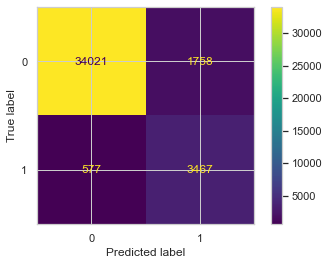

In [29]:
plot_cm(y_test, predictions, model)

Попробуем добавить перебор параметров

In [30]:
param_distrs = {
                'C':optuna.distributions.LogUniformDistribution(0.1, 30),
                'max_iter':optuna.distributions.IntUniformDistribution(800, 1500, 100)
                }

opt_search = optuna.integration.OptunaSearchCV(model, param_distrs, cv = 5,
                                                n_trials=100, scoring='f1', timeout=500)

In [31]:
opt_search.fit(tf_idf, y_train)

[I 2022-11-21 22:56:43,097] A new study created in memory with name: no-name-1fa5accd-c36d-4382-91da-3536ca9858a5
[I 2022-11-21 22:56:55,074] Trial 0 finished with value: 0.7350924487576995 and parameters: {'C': 0.5124440681269508, 'max_iter': 1100}. Best is trial 0 with value: 0.7350924487576995.
[I 2022-11-21 22:57:05,286] Trial 1 finished with value: 0.7276324683874122 and parameters: {'C': 0.3513252519603397, 'max_iter': 900}. Best is trial 0 with value: 0.7350924487576995.
[I 2022-11-21 22:57:28,788] Trial 2 finished with value: 0.7508394319083666 and parameters: {'C': 1.4932551960305789, 'max_iter': 800}. Best is trial 2 with value: 0.7508394319083666.
[I 2022-11-21 22:57:48,994] Trial 3 finished with value: 0.7459563208778256 and parameters: {'C': 0.9945521120390847, 'max_iter': 1100}. Best is trial 2 with value: 0.7508394319083666.
[I 2022-11-21 22:57:59,251] Trial 4 finished with value: 0.7291215504876085 and parameters: {'C': 0.3801795324339297, 'max_iter': 1500}. Best is tri

OptunaSearchCV(estimator=LogisticRegression(class_weight='balanced', n_jobs=-1,
                                            random_state=12345),
               n_trials=100,
               param_distributions={'C': FloatDistribution(high=30.0, log=True, low=0.1, step=None),
                                    'max_iter': IntDistribution(high=1500, log=False, low=800, step=100)},
               scoring='f1', timeout=500)

In [32]:
print(f'Best params: {opt_search.best_params_}')
print(f'Best score: {opt_search.best_score_}')
print(f'Best estimator: {opt_search.best_estimator_}')

Best params: {'C': 7.292907540172378, 'max_iter': 1000}
Best score: 0.7604827008240094
Best estimator: LogisticRegression(C=7.292907540172378, class_weight='balanced', max_iter=1000,
                   n_jobs=-1, random_state=12345)


In [48]:
opt_model = opt_search.best_estimator_

opt_predictions = opt_model.predict(tf_idf_test)

opt_f1 = f1_score(y_test, opt_predictions, average='binary')

print(f'F1 у LogReg с перебором параметров: {round(opt_f1, 2)}')

F1 у LogReg с перебором параметров: 0.76


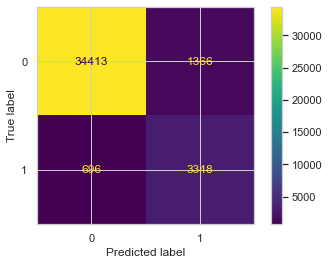

In [34]:
plot_cm(y_test, opt_predictions, opt_model)

## LightGBM

In [54]:
params = {
    'learning_rate': 0.1,
    "num_leaves": 50,  
    "max_depth": 5,
    "max_bin" : 100,
    "num_iterations": 2000,
    "metric" : 'auc'
}
lgb_model = lgb(**params, n_jobs=-1)
lgb_model.fit(tf_idf, y_train, eval_set=(tf_idf_test, y_test), verbose=100)

lgb_preds = lgb_model.predict(tf_idf_test)

lgb_f1_res = f1_score(y_test, lgb_preds)

[100]	valid_0's auc: 0.93302
[200]	valid_0's auc: 0.947149
[300]	valid_0's auc: 0.95422
[400]	valid_0's auc: 0.958147
[500]	valid_0's auc: 0.959842
[600]	valid_0's auc: 0.961376
[700]	valid_0's auc: 0.962504
[800]	valid_0's auc: 0.963297
[900]	valid_0's auc: 0.963699
[1000]	valid_0's auc: 0.964218
[1100]	valid_0's auc: 0.964741
[1200]	valid_0's auc: 0.965028
[1300]	valid_0's auc: 0.965168
[1400]	valid_0's auc: 0.965114
[1500]	valid_0's auc: 0.965351
[1600]	valid_0's auc: 0.965404
[1700]	valid_0's auc: 0.965332
[1800]	valid_0's auc: 0.965268
[1900]	valid_0's auc: 0.965305
[2000]	valid_0's auc: 0.965206


In [49]:
print(f'F1 у модели LBG: {round(lgb_f1_res, 2)}')

F1 у модели LBG: 0.78


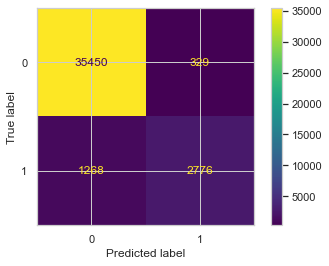

In [39]:
plot_cm(y_test, lgb_preds, lgb_model)

## Общая таблица моделей

In [40]:
all_models = pd.DataFrame([f1_res, opt_f1, lgb_f1_res], 
                 
                 columns=['f1_score'], 
                 index=['LogReg', 'Tune_LogReg', 'LightGBM'])

all_models.sort_values(by='f1_score', ascending=False)

,f1_score
LightGBM,0.776612
Tune_LogReg,0.764558
LogReg,0.748085


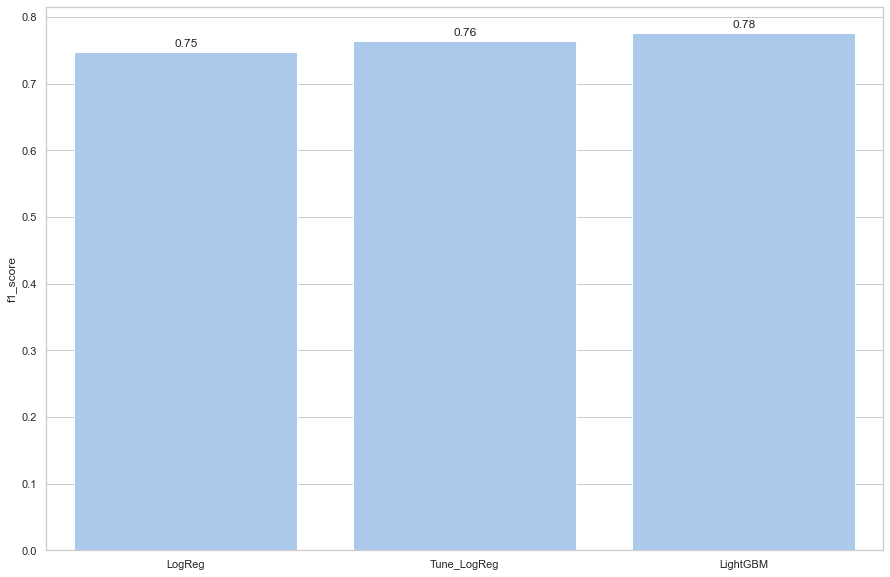

In [44]:
f, ax = plt.subplots(figsize=(15, 10))


sns.set_color_codes("pastel")
sns.barplot(x=all_models.index, y='f1_score', data=all_models.sort_values(by='f1_score'), label="f1_score", color='b')


for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
    value = '{:.2f}'.format(p.get_height())
    ax.text(_x, _y, value, ha="center")

## Вывод


Модель с необходимой точностью создана.

**Лучший результат показала LightGBM: 0.78**

Метод TF-IDF оказался точнее в данном случае.

Модель BERT оказалась не совсем подходящей для данной задачи:
- требует в разы больше мощности для вычисления
- затраты времени на настройку и проверку вариантов значительно выше